In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

%load_ext autoreload
%autoreload 2

In [2]:
with open("data/pkl_files/trimmed_inputs.pkl", "rb") as fp:
    complete_inputs = pickle.load(fp)
with open("data/pkl_files/trimmed_outputs.pkl", "rb") as fp:
    outputs = pickle.load(fp)

In [3]:
inputs = np.reshape(complete_inputs[:,0:3,:,:], (complete_inputs.shape[0], 3, complete_inputs.shape[2], complete_inputs.shape[3]))


In [4]:
# Sanity check
print(inputs.shape)
print(outputs.shape)

(25650, 3, 32, 32)
(25650, 1, 32, 32)


In [5]:
outputs[outputs > 0] = 1

In [ ]:
# Sanity Check
idx = np.random.randint(0, inputs.shape[0])
def plot_sampled_images(idx):    
    cropped_seg_img = outputs[idx,0,:,:]
    plt.imshow(cropped_seg_img)
    plt.show()
    cropped_flair_img = inputs[idx,0,:,:]
    plt.imshow(cropped_flair_img)
    plt.show()
plot_sampled_images(idx)

In [6]:
np.random.seed(0)
shuffled_idxs = list(range(inputs.shape[0]))
np.random.shuffle(shuffled_idxs)
train_cutoff = int(inputs.shape[0]*80/100)
val_cutoff = int(inputs.shape[0]*90/100)

train_inputs = []
train_outputs = []
val_inputs = []
val_outputs = []
test_inputs = []
test_outputs = []

for iteration, idx in enumerate(shuffled_idxs):
    if iteration < train_cutoff:
        train_inputs.append(inputs[idx])
        train_outputs.append(outputs[idx])
    elif iteration < val_cutoff:
        val_inputs.append(inputs[idx])
        val_outputs.append(outputs[idx])
    else:
        test_inputs.append(inputs[idx])
        test_outputs.append(outputs[idx])

In [7]:
# sanity check
print(len(train_inputs))
print(len(train_outputs))
print(len(val_inputs))
print(len(val_outputs))
print(len(test_inputs))
print(len(test_outputs))

20520
20520
2565
2565
2565
2565


In [8]:
train_inputs = np.asarray(train_inputs).astype(np.float32)
val_inputs = np.asarray(val_inputs).astype(np.float32)
test_inputs = np.asarray(test_inputs).astype(np.float32)

train_inputs_mean = np.mean(train_inputs, axis=0)
train_inputs_std = np.std(train_inputs, axis=0)

train_inputs -= train_inputs_mean
train_inputs /= train_inputs_std
val_inputs -= train_inputs_mean
val_inputs /= train_inputs_std
test_inputs -= train_inputs_mean
test_inputs /= train_inputs_std

In [9]:
train_outputs = np.asarray(train_outputs).astype(np.float32)
n_tumor_pixels = np.count_nonzero(train_outputs)
total_output_pixels = train_outputs.shape[0]*train_outputs.shape[2]*train_outputs.shape[3]
frac_tumor = n_tumor_pixels / total_output_pixels
print(frac_tumor)

0.06759054618969298


In [10]:
train_data = []
val_data = []
test_data = []

for idx in range(train_inputs.shape[0]):
    train_data.append([train_inputs[idx], train_outputs[idx]])
for idx in range(val_inputs.shape[0]):
    val_data.append([val_inputs[idx], val_outputs[idx]])
for idx in range(test_inputs.shape[0]):
    test_data.append([test_inputs[idx], test_outputs[idx]])

In [11]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=32)

print(len(train_loader))
print(len(train_data))

642
20520


In [12]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial
print(torch.cuda.is_available())

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 30

print('using device:', device)

True
using device: cuda


In [13]:
from models.unet import *

In [15]:
"""
in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
"""
def test_UNet():
    channels_in = 3
    n_classes = 2
    x = torch.zeros((32, 3, 32, 32), dtype=dtype)
    model = UNet(channel_in=channels_in, classes=n_classes)
    scores = model(x)
    print(scores.size())
test_UNet()

torch.Size([32, 2, 32, 32])


In [38]:
# Defining all parameters 
print_every = 25
loss_history = []
learning_rate = 0.5e-2
input_channels = 3
n_classes = 2
model = UNet(channel_in=input_channels, classes=n_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
# criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, n_blank_pixel/float(n_tumor_pixels)]).cuda()) 
criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, (total_output_pixels-n_tumor_pixels)/float(n_tumor_pixels)]).cuda()) 
# could try dice loss? not sure how it would work nor how it expects its parameters though lol

if USE_GPU and torch.cuda.is_available():
    model.cuda()

In [39]:
def create_masks(x):
    mask = np.zeros((n_classes, x.shape[0], x.shape[1]))
    for c in range(n_classes):
        mask[c] = x == c
    return mask

In [40]:
def compute_iou(scores, output):  
    scores = scores.astype(np.bool)
    output = output.astype(np.bool)
    overlap = scores*output
    union = scores+output # Logical OR
    IOU = (overlap.sum())/(float(union.sum())+1e-10) 
    return IOU

In [41]:
def iou_metric(preds, labels):
    # preds and labels are of size (64, 32, 32)
    # return average iou value for each class
    numpy_preds = preds.cpu().numpy()  
    numpy_labels = labels.cpu().numpy()
    
    iou_tracker = np.zeros((numpy_preds.shape[0], n_classes))
    # get the masks
    for idx in range(numpy_preds.shape[0]):
        """plt.title('Segmented Output')
        plt.imshow(numpy_preds[idx,:,:])
        plt.show()
        plt.title('Ground Truth')
        plt.imshow(numpy_labels[idx,:,:])
        plt.show()"""
        pred_mask = create_masks(numpy_preds[idx])
        label_mask = create_masks(numpy_labels[idx])
        for c in range(n_classes):
            iou_tracker[idx, c] = compute_iou(pred_mask[c], label_mask[c])
        # print(iou_tracker[idx])
    # print(np.mean(iou_tracker, axis=0))
    return np.mean(iou_tracker, axis=0)     

In [42]:
def check_iou(loader, model):
    all_iou = np.zeros((len(loader),n_classes))

    with torch.no_grad():
        for t, (x,y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float).view(y.shape[0], 32, 32)
            scores = model(x)
            _, preds = scores.max(1)
            
            all_iou[t] = iou_metric(preds, y)
    # print(np.mean(all_iou, axis=0))
    return np.mean(all_iou, axis=0)

In [43]:
check_iou(val_loader, model)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


array([0.        , 0.06215225])

In [44]:
def plot_output(scores, y):
    with torch.no_grad():
        _, preds = scores.max(1)
        numpy_scores = preds.cpu().numpy().astype(np.uint8)
        numpy_truth = y.cpu().numpy().astype(np.uint8)
        idx = np.random.randint(1, y.shape[0])
        while(np.count_nonzero(numpy_truth[idx]) < int(0.10*32*32)):
            idx = np.random.randint(1, y.shape[0])
        plt.title('Segmented Output')
        plt.imshow(numpy_scores[idx,:,:])
        plt.show()
        plt.title('Ground Truth')
        plt.imshow(numpy_truth[idx,:,:])
        plt.show()

In [45]:
import torch.nn.functional as F

val_iou_history = []
train_iou_history = []
plot_every = 100
def train(model, optimizer, epochs=1):
    model = model.to(device=device)
    loss_history.clear()
    val_iou_history.clear()
    train_iou_history.clear()
    for e in range(epochs):
        for t, (x,y) in enumerate(train_loader):
            model.train()
            x = x.to(device=device, dtype=dtype)
            labels = y.to(device=device, dtype=torch.long).view(y.shape[0], 32, 32)
            # print(labels.shape)

            scores = model(x)
            # print(scores.shape)

            loss = criterion(scores, labels)
            # loss = F.cross_entropy(scores, labels, weight=torch.FloatTensor([1/(float(26265600-1762336)), 1/(float(1762336))]).cuda())
            loss_history.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print(t)
            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                val_iou = check_iou(val_loader, model)
                val_iou_history.append(val_iou)
                train_iou = check_iou(train_loader, model)
                train_iou_history.append(train_iou)
                print('Validation IOU: ', val_iou)
                print('Training IOU: ', train_iou)
            # if t % plot_every == 0:
                # plot_output(scores, labels)
train(model, optimizer, epochs=250)

Epoch 0, Iteration 0, loss = 0.7237
Validation IOU:  [0.         0.06310033]
Training IOU:  [0.         0.06763351]
Epoch 0, Iteration 25, loss = 0.6328
Validation IOU:  [0.         0.06215225]
Training IOU:  [0.         0.06751159]
Epoch 0, Iteration 50, loss = 0.7106
Validation IOU:  [0.         0.06215225]
Training IOU:  [0.         0.06761369]
Epoch 0, Iteration 75, loss = 0.6669
Validation IOU:  [0.02786961 0.06252606]
Training IOU:  [0.02713037 0.06805595]
Epoch 0, Iteration 100, loss = 0.7450
Validation IOU:  [0.16471436 0.06592142]
Training IOU:  [0.16547081 0.07130487]
Epoch 0, Iteration 125, loss = 0.6746
Validation IOU:  [0.23758264 0.06690081]
Training IOU:  [0.24006084 0.07280316]
Epoch 0, Iteration 150, loss = 0.7156
Validation IOU:  [0.32428283 0.06468786]
Training IOU:  [0.32447414 0.07115551]
Epoch 0, Iteration 175, loss = 0.6709
Validation IOU:  [0.52386132 0.05510607]
Training IOU:  [0.52159991 0.05976416]
Epoch 0, Iteration 200, loss = 0.6580
Validation IOU:  [0.674

KeyboardInterrupt: 

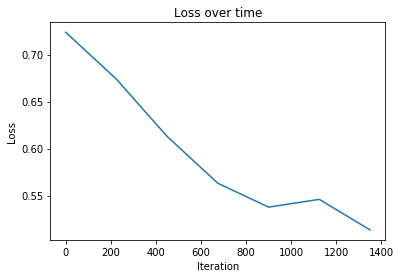

In [50]:
fig = plt.figure()
plt.title('Loss over time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(range(len(loss_history))[0::225], loss_history[0::225])
# plt.plot(range(len(loss_history)), loss_history)
fig.savefig('Binary Problem Loss - Poster Session.png')

In [25]:
val_hist = np.asarray(val_iou_history)
train_hist = np.asarray(train_iou_history)

In [26]:
print(val_hist.shape)
print(train_hist.shape)

(2299, 2)
(2298, 2)


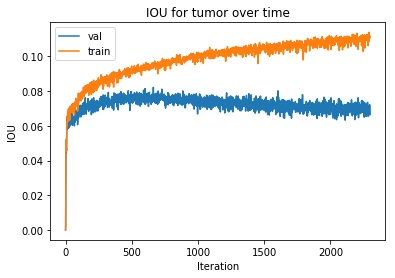

In [33]:
fig = plt.figure()
plt.title('IOU for tumor over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,1], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,1], label='train')
plt.legend()
fig.savefig('IOU for tumor - Poster Session.png')

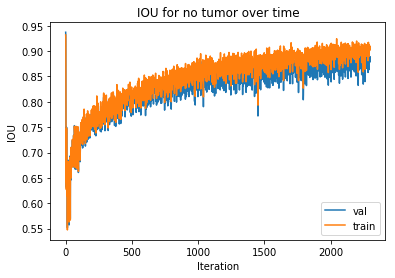

In [34]:
fig = plt.figure()
plt.title('IOU for no tumor over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,0], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,0], label='train')
plt.legend()
fig.savefig('IOU for no tumor - Poster Session.png')

In [32]:
check_iou(test_loader, model)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


array([0.88586248, 0.06868494])

Overfitting small dataset

In [ ]:
small_inputs = inputs[:40]
small_outputs = outputs[:40]

np.random.seed(0)
shuffled_idxs = list(range(small_inputs.shape[0]))
np.random.shuffle(shuffled_idxs)
train_cutoff = int(small_inputs.shape[0]*80/100)

small_train_inputs = []
small_train_outputs = []
small_val_inputs = []
small_val_outputs = []


for iteration, idx in enumerate(shuffled_idxs):
    if iteration < train_cutoff:
        small_train_inputs.append(small_inputs[idx])
        small_train_outputs.append(small_outputs[idx])
    else:
        small_val_inputs.append(small_inputs[idx])
        small_val_outputs.append(small_outputs[idx])

n_tumor_pixels = np.count_nonzero(np.asarray(small_train_outputs))
total_output_pixels = 32*32*32
frac_tumor = n_tumor_pixels / total_output_pixels


In [ ]:
small_train_inputs = np.asarray(small_train_inputs).astype(np.float32)
small_val_inputs = np.asarray(small_val_inputs).astype(np.float32)

small_train_inputs_mean = np.mean(small_train_inputs, axis=0)
small_train_inputs_std = np.std(small_train_inputs, axis=0)

small_train_inputs -= small_train_inputs_mean
small_train_inputs /= small_train_inputs_std
small_val_inputs -= small_train_inputs_mean
small_val_inputs /= small_train_inputs_std


In [ ]:
small_train_data = []
small_val_data = []
test_data = []

for idx in range(small_train_inputs.shape[0]):
    small_train_data.append([small_train_inputs[idx], small_train_outputs[idx]])
for idx in range(small_val_inputs.shape[0]):
    small_val_data.append([small_val_inputs[idx], small_val_outputs[idx]])

In [ ]:
print(len(small_train_data))
print(len(small_val_data))

In [ ]:
small_train_loader = torch.utils.data.DataLoader(small_train_data, shuffle=True, batch_size=32)
small_val_loader = torch.utils.data.DataLoader(small_val_data, shuffle=True, batch_size=32)


In [ ]:
print_every = 25
learning_rate = 1e-1
input_channels = 3
n_classes = 2
model = UNet(channel_in=input_channels, classes=n_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
# criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, n_blank_pixel/float(n_tumor_pixels)]).cuda()) 
# criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, 35]).cuda()) 
criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, (total_output_pixels-n_tumor_pixels)/float(n_tumor_pixels)]).cuda()) 

# could try dice loss? not sure how it would work nor how it expects its parameters though lol

In [ ]:
val_iou_history = []
loss_history = []
train_iou_history = []
plot_every = 100
def train(model, optimizer, epochs=1):
    model = model.to(device=device)
    loss_history.clear()
    val_iou_history.clear()
    train_iou_history.clear()
    for e in range(epochs):
        for t, (x,y) in enumerate(small_train_loader):
            model.train()
            x = x.to(device='cuda', dtype=dtype)
            labels = y.to(device=device, dtype=torch.long).view(y.shape[0], 32, 32)
            # print(labels.shape)

            scores = model(x)
            # print(scores.shape)

            loss = criterion(scores, labels)
            # loss = F.cross_entropy(scores, labels, weight=torch.FloatTensor([1/(float(26265600-1762336)), 1/(float(1762336))]).cuda())
            loss_history.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print(t)
            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                val_iou = check_iou(small_val_loader, model)
                val_iou_history.append(val_iou)
                train_iou = check_iou(small_train_loader, model)
                train_iou_history.append(train_iou)
                print('Validation IOU: ', val_iou)
                print('Training IOU: ', train_iou)
            # if t % plot_every == 0:
                # plot_output(scores, labels)
train(model, optimizer, epochs=5000)

In [ ]:
plt.title('Loss over time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(range(len(loss_history)), loss_history)

In [ ]:
val_hist = np.asarray(val_iou_history)
train_hist = np.asarray(train_iou_history)

In [ ]:
plt.title('IOU for tumor over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,1], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,1], label='train')
plt.legend()

In [ ]:
plt.title('IOU for no tumor over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,0], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,0], label='train')
plt.legend()